In [93]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import gutenberg, stopwords
from spacy.en import English
from collections import Counter
%matplotlib inline

Now that you've been introduced to some NLP tools, let's try them out in a small project.  Our goal is to use NLP to identify marriage proposals in the works of Jane Austen.  We'll be using the Gutenberg Austen corpus.  This doesn't have any annotations, so we can't build a supervised model. Instead, we will use NLP to try and extract the sense from each sentence and pull out the ones having to do with marriage proposals.

Here is a sketch of the analysis plan:

1.  Clean the data.
2.  Parse using spaCy:
 * Set everything to lowercase.
 * Organize into a list of sentence-strings.
3.  Calculate Austen-specific word vectors using word2vec
 * We could use the pre-calculated GloVe vectors, which are built-in to spaCy from a very large word2vec model using contemporary sources.  However, Austen's language is different enough that an Austen-specific vector model may work better.
4.  Calculate weights for each word in each sentence using tfidf
5.  Use word2vec to score how similar each word is to the phrase 'making violent love,' which in the language of the period refers to a passionate proposal of marriage
6.  Score each sentence as the mean of the similarity scores of each word in the sentence weighted by their respective tfidf scores.

Sentences with the highest scores should be those that describe marriage proposals.

Let's see if it works!

In [94]:
def text_cleaner(text):
    # Visual inspection identifies forms of punctuation spaCy does not recognize.  Better get rid of them now!
    text=re.sub(r'-',' ',text)
    text=re.sub(r'_','',text)
    # Getting rid of headings in square brackets
    text=re.sub("[\[].*?[\]]", "", text)
    # Getting rid of chapter titles
    text=re.sub(r'Chapter \d+','',text)
    # Getting rid of extra whitespace
    text=' '.join(text.split())
    return text



# Importing all the Austen in the gutenberg corpus
austen=""
for novel in ['persuasion','emma','sense']:
    work=gutenberg.raw('austen-'+novel+'.txt')
    austen=austen+work

#Now let's do a little cleaning and load the data into spaCy.
austen_clean=text_cleaner(austen)
parser = English()

Austen = parser(austen_clean)

#And organize into sentences.  Because word2vec, tfidf, and human eyes each prefer different formats, we store the sentences three different ways.
# Storing each sentence as a list of processed words.
sentences = []
# Storing each sentence as a processed string.
sentences_string=[]
# Storing each sentence as a raw string.
sentences_full=[]

for span in Austen.sents:
    # go from the start to the end of each span, returning each token in the sentence
    sentence = [Austen[i] for i in range(span.start, span.end)]
    #Organizing into human-readable sentence-by-sentence output
    sentence_full = [token.text for token in sentence]
    sentences_full.append(' '.join(sentence_full))
    #Convert to lowercase 
    sentence = [token.lower_ for token in sentence]
    #Creating a list of lists of strings
    sentences.append(sentence)
    #Creating one string that holds all content, for tfidf.
    sentences_string.append(' '.join(sentence))

#Flattening the sentences lists into one list, for easier word counting
onelist = []
list(map(onelist.extend, sentences))

print('Original sentence:',sentences_full[20])
print('Processed sentence:', sentences[20])
print('We have {} sentences made up of {} words.  There are {} unique words'.format(len(sentences),len(austen_clean), len(set(onelist))))
                        

Original sentence: Elizabeth had succeeded , at sixteen , to all that was possible , of her mother 's rights and consequence ; and being very handsome , and very like himself , her influence had always been great , and they had gone on together most happily .
Processed sentence: ['elizabeth', 'had', 'succeeded', ',', 'at', 'sixteen', ',', 'to', 'all', 'that', 'was', 'possible', ',', 'of', 'her', 'mother', "'s", 'rights', 'and', 'consequence', ';', 'and', 'being', 'very', 'handsome', ',', 'and', 'very', 'like', 'himself', ',', 'her', 'influence', 'had', 'always', 'been', 'great', ',', 'and', 'they', 'had', 'gone', 'on', 'together', 'most', 'happily', '.']
We have 15673 sentences made up of 2005527 words.  There are 10409 unique words


In [148]:
# Looking at the most common words

#Counting frequency of words
counts = Counter(onelist)
#List of words
words = counts.keys()

#Creating a data frame with one column that holds the counts for each word
wordcounts = pd.DataFrame(counts,index=words)
wordcounts.drop(wordcounts.columns[1:], inplace=True)
wordcounts=pd.DataFrame(wordcounts.iloc[0,:],index=words)
wordcounts.columns=['count']

#Sorting by count
wordcounts=wordcounts.sort_values(by="count",axis=0)
print(wordcounts.head())

           count
billiards      1
sunny          1
betweens       1
maps           1
fits           1


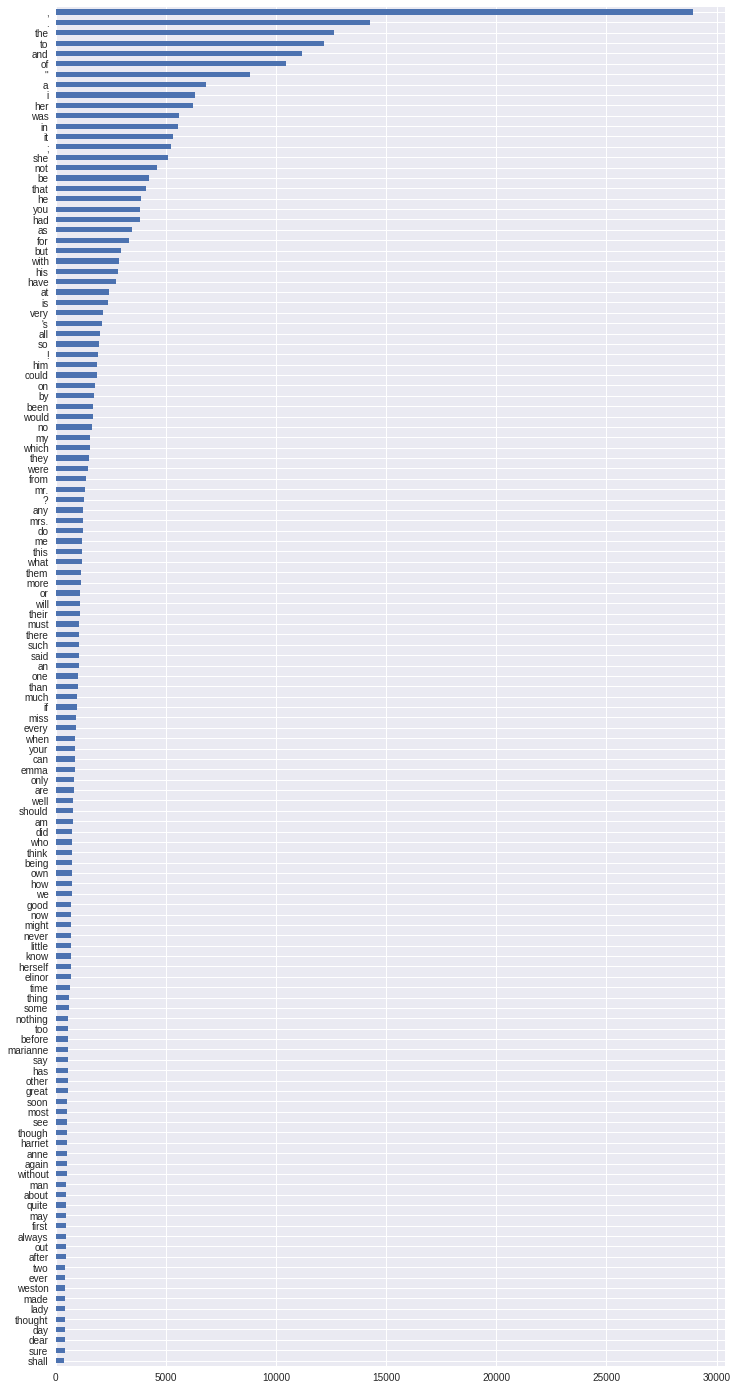

In [147]:
# Showing the words that occur more than 400 times in the corpus

fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 12 and height to 9
fig_size[0] = 12
fig_size[1] = 25
plt.rcParams["figure.figsize"] = fig_size

fig=wordcounts[wordcounts>400].dropna(axis=0).plot(kind='barh',legend=False)
plt.show()

# Of Stopwords and Punctuation

You may be wondering why we didn't exclude stopwords and punctuation when we processed the text in spaCy.  Unlike many NLP approaches, word2vec doesn't necessarily perform better with common words stripped out. Because it operates by looking at the context of surrounding words, removing some of those words can have strong effects on the similarities perceived by word2vec.  This is also why we're using the original words rather than reducing them to lemmas- with a corpus as small as ours, word2vec needs all the information we can give it!

Our other NLP method, tfidf, which does perform better when common words are removed, has a 'max_df' option to drop very common words during processing, so we'll use that then. 

In [97]:
import gensim
from gensim.models import word2vec

model = word2vec.Word2Vec(sentences,
                          workers=4, # Number of threads to run in parallel, if your computer does parallel processing
                          min_count = 2, # Minimum word count threshold   
                          window=6, # Number of words around target word to consider    
                          sg=0, # Use CBOW because our corpus is small
                          sample=1e-3 , # Penalize frequent words
                          size=300, # Word vector length   
                          hs=1 # Use hierarchical softmax
                         )

print('done!')

done!


In [149]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.1, # drop words that occur in more than 10 percent of the sentences- here's where we get rid of those stopwords!
                             min_df=20, # only use words that appear at least this many times
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting.
                             norm=u'l2', #Applies a correction factor so that longer sentences and shorter sentences get treated equally.
                             smooth_idf=True #Adds 1 to all sentence frequencies, as if an extra sentence existed that used every word once.  Prevents divide-by-zero errors.
                            )

#Applying the vectorizer
sentences_tfidf=vectorizer.fit_transform(sentences_string)
print("Number of features: %d" % sentences_tfidf.get_shape()[1])

#Reshapes the vectorizer output into something easier to work with.
sentences_tfidf_csr = sentences_tfidf.tocsr()

#A list of dictionaries, one per sentence
tfidf_bysentence = [{} for _ in range(0,sentences_tfidf_csr.shape[0])]
#List of features
terms = vectorizer.get_feature_names()
#For each sentence, lists the feature words and their tf-idf scores
for i, j in zip(*sentences_tfidf_csr.nonzero()):
    tfidf_bysentence[i][terms[j]] = sentences_tfidf_csr[i, j]



Number of features: 1522


In [145]:

#Takes a list of sentences, list of tfidf weights, and a list of words and returns a data frame where each word from the wordlist is a column and each row is a sentence.
#For each column, the score is the similarity of that word to the words 'making violent love' weighted by the tfidf for the word.
def bow_features(sentences,weights,word_names):
    #Data frame of words:
    sentencesdf=pd.DataFrame(columns=word_names)
    #Adding sentences:
    sentencesdf['text_sentence']=sentences
    #Setting all the count columns to zero.
    sentencesdf.loc[:,word_names]=0
    #Processing each sentence :
    for i, sentence in enumerate(sentences):
        #Keeping only the words in the word list.
        elements_common=[item for item in sentence if item in set(word_names) ]
        #For each word, multiplying its weight by the similarity to 'making violent love'.
        #Words that appear more than once in a sentence are only counted the first time.
        for element in set(elements_common):
            sentencesdf.loc[i,element]=weights[i][element]*model.wv.n_similarity(['making','violent','love'],[element])
        #This counter is just to make sure the kernel didn't hang
        if i%500==0:
            print(i)
    return sentencesdf



In [146]:
print('start')
features=bow_features(sentences,tfidf_bysentence,terms)
print('done')

start
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
done


# How High?

Now that we have the ingredients for computing our sentence-level scores, we need to decide what our 'this is probably a proposal' cutoff point should be.  We can do that by looking at the distribution and making an educated guess.  There probably are less than 5 marriage proposals per Austen novel, and we have three novels, so if our scores are good then taking the 15 highest scores should give us the proposals.

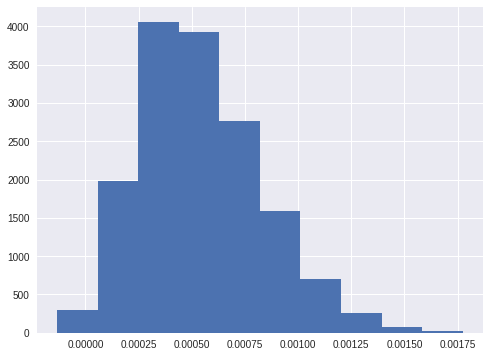

In [154]:
fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 12 and height to 9
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

marriage_proposal_score=features[features.columns.difference(['text_sentence'])].mean(axis=1)
marriage_proposal_score.hist()
plt.show()

In [158]:

is_marriage=marriage_proposal_score>.00175
indices=marriage_proposal_score.sort_values(ascending=False)[0:16].index.tolist()



for index in indices:
    print(sentences_full[index],'\n')


But when the second moment had passed , when she found every doubt , every solicitude removed , compared her situation with what so lately it had been , saw him honourably released from his former engagement , saw him instantly profiting by the release , to address herself and declare an affection as tender , as constant as she had ever supposed it to be , she was oppressed , she was overcome by her own felicity ; and happily disposed as is the human mind to be easily familiarized with any change for the better , it required several hours to give sedateness to her spirits , or any degree of tranquillity to her heart . 

She had previously , in the anticipation of their marriage , been very apprehensive of losing her friend by it ; but on being assured that he could have made no attempt of that nature , since he did not even know her to be in Bath , it immediately occurred , that something might be done in her favour by the influence of the woman he loved , and she had been hastily prep

# The Verdict

Oh dear.  Of the 15 sentences, only five refer to engagements at all, and only three are marriage proposals.  Taken in the context of the 15,673 sentences we started with, being able to find five of our suspected 15 sentences isn't bad, but from the perspective of doing something useful, this isn't great.  

# The Drill

Can this model be improved?  Most assuredly.  Options include adding more text to improve the word2vec similarity ratings (other Jane Austen novels are available in plain text with Project Gutenberg), changing the words used to compute similarity ('marriage proposal' doesn't work well, surprisingly, but other words may), adding a penalty for certain words that we don't want to see, or taking a totally new approach using features and unsupervised learning.

Generate at least two new solutions (modifications or totally novel ones) and evaluate how well they compare to this one.  
